# Player Injury Relation Learning
## Introduction
In this ddlite app, we'll build a relation tagger from scratch. The generalized extraction and learning utilities provided by ddlite will allow us to turn a sampling of NBA news and some basic domain knowledge into an automated tagging system. We have almost comprehensive dictionaries of NBA player's name and injury parts, but applying a simple matching rule might yield a lot of false positives. Our goal is to use distant supervision to improve precision.


In [1]:
%load_ext autoreload
%autoreload 2

import cPickle, os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

## Load relations from file

In [2]:
R = Relations('data/temp/relation_saved_send_v4.pkl')

In [3]:
R.num_candidates()

516

Load dictionary for status(keyword) of injury

In [4]:

get_injury_state = [line.rstrip() for line in open('data/dictionary/state_dic_1.tsv')]
is_recover_state = [line.rstrip() for line in open('data/dictionary/state_dic_recover.tsv')]
is_aggrevated_state = [line.rstrip() for line in open('data/dictionary/state_dic_aggregate.tsv')]
is_return_state = [line.rstrip() for line in open('data/dictionary/state_dic_return.tsv')]


## Feature Extraction
Now we'll use ddlib via ddlite's DDLiteModel class to extract features for each relation. This can take a little while, so if the script has already been run, we'll reload it.

In [5]:
feats = None

pkl_f = 'data/temp/feats_v2.pkl'
try:
    with open(pkl_f, 'rb') as f:
        feats = cPickle.load(f)
except:
    %time R.extract_features()
    with open(pkl_f, 'w+') as f:
        cPickle.dump(R.feats, f)

DDL = DDLiteModel(R, feats)

print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 10171 features for each of 516 mentions


## Label ground truth candidates using MindTagger
In order to evaluate our labeling functions and learning results, we'll create a small set of ground truth labels for some candidates using Mindtagger. This will highlight each candidate in the sentence in which it appears. We set the response to yes if it is a mention of gene, and no otherwise. Here I sample 80 candiates from whole set.

In [66]:
DDL.open_mindtagger(num_sample=80, width='100%', height=1600)

Making sure MindTagger is installed. Hang on!


In [88]:
# Here we add these tags to ground truth set
DDL.add_mindtagger_tags()

In order to avoid tagging multiple times, if tagging has been done once, the script will load the existing tags array to ground truth.

In [135]:
groud_truth_path = 'data/temp/ground_truth_7.pkl'
try:
    with open(groud_truth_path, 'rb') as f:
        gt = cPickle.load(f)
        DDL.update_gt(gt[1],gt[0])
except:
    with open(groud_truth_path, 'w+') as f:
        cPickle.dump(DDL.get_labeled_ground_truth(), f)

## Here I set the validation set fraction of ground truth set to 30%        
DDL.gt.set_holdout(validation_frac=0.3)
print DDL.gt.validation
print len(DDL.gt.get_labeled_ground_truth()[1])



[414 350 409 108 259 138 240 293  82  61 372 104 439  93 126 436 488  31
  48  95 115 226 496 421 325]
85


## Writing labeling functions
We'll use data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true player-injury relation. Since our training data is not manually labeled, we'll generate many (potentially noisy) labels as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite. Writing labeling functions is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions. These can be used either to create a simple standalone app, or to plug into DeepDive. Labeling functions, or LFs, are functions that take an Candidate object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). But in order to give different weight to labeing functions to identify their importance, it may return different values.

In [136]:
## helper function for labeling
def get_idxs_by_label(r,label): return r.e1_idxs if r.e1_label == label else r.e2_idxs
get_idxs_by_label(R[1],'Injury Part')
injury_dict=[line.rstrip() for line in open('data/dictionary/injury_dic.tsv')]
def has_injury_keyword(r): 
    for x in injury_dict:
        if (x in r.get_attr_seq('lemmas',range(max(r.e1_idxs)+1,min(r.e2_idxs)))):
            return True
    return False
def has_person_tag(r):
    return ('PERSON' in r.get_attr_seq('ners',range(max(r.e1_idxs)+1,min(r.e2_idxs))))
        

In [144]:
## For learning 
verb_tags = ['VB','VBD','VBN','VBP','VBZ','VBG']
noun_tags = ['NN','NNS','NNPS','NNP']


def general_too_faraway(r): return -1 if (r.e1_idxs[-1] - r.e2_idxs[0])>12 else 0
def general_pre_limit(r): return 2 if ('right' or 'left') in r.get_attr_seq('lemmas',range(min(r.e2_idxs)-4,min(r.e2_idxs))) else 0
def general_not_noun(r):
    for i in r.get_attr_seq('poses', get_idxs_by_label(r,'Injury Part')):
        if i not in noun_tags: return -100
    return 1
def another_name_between(r): return -1 if (has_person_tag(r)) else 1
def has_injury_between(r): return 1 if (has_injury_keyword(r) and not has_person_tag(r)) else -1
def remove_head_coach(r): return -100 if (('coach' in r.post_window2('lemmas',1)+r.pre_window2('lemmas',1)) or ('coach' in r.post_window1('lemmas',1)+r.pre_window1('lemmas',1))) else 0
general_LFs = [general_pre_limit,general_too_faraway,general_not_noun,remove_head_coach,another_name_between]
key_word = get_injury_state+is_recover_state+is_aggrevated_state+is_return_state
    

def has_key_word(r): 
    for x in key_word:
        if x in r.lemmas:
            return 2
    return 0


After writing the LFs, we simply collect them and apply them to mentions. If we define more LFs later, we can apply them incrementally or overwrite all the LFs so far.

In [146]:
#LFs = [get_injury,is_recover,is_aggrevate,is_return] + general_LFs
LFs = general_LFs+[has_key_word]
DDL.apply_lfs(LFs, clear=True)

## Labeling functions performance
We'll use ddlite's LF assessment utilities to debug and analyze our LFs before running inference. First, we'll generate summary plots which show the following:
Do the LFs cover the data well or do we have many candidates for which all of the LFs abstained?
Is there overlap between the LFs? Do many return positive or negative labels for the same candidate?
Do the LFs conflict with each other? Do candidates tend to have many of one type of label, or a mix?

In [148]:
DDL.print_lf_stats()

LF stats on training set
Coverage:	100.000%
Overlap:	84.690%
Conflict:	20.349%


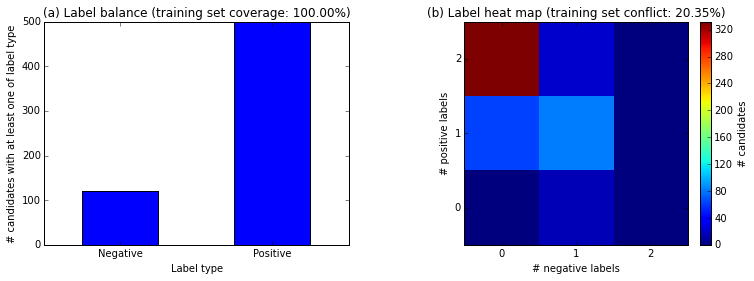

In [149]:
DDL.plot_lf_stats()

Begin training for mu = 0.001
	Learning epoch = 0	Gradient mag. = 1.215377
	Learning epoch = 100	Gradient mag. = 1.179391
	Learning epoch = 200	Gradient mag. = 1.144136
	Learning epoch = 300	Gradient mag. = 1.131433
	Learning epoch = 400	Gradient mag. = 1.126811
Final gradient magnitude for mu=0.001: 1.125
Begin training for mu = 0.01
	Learning epoch = 0	Gradient mag. = 1.215377
	Learning epoch = 100	Gradient mag. = 1.179642
	Learning epoch = 200	Gradient mag. = 1.144683
	Learning epoch = 300	Gradient mag. = 1.132110
	Learning epoch = 400	Gradient mag. = 1.127538
Final gradient magnitude for mu=0.010: 1.126
Begin training for mu = 0.1
	Learning epoch = 0	Gradient mag. = 1.215377
	Learning epoch = 100	Gradient mag. = 1.189721
	Learning epoch = 200	Gradient mag. = 1.159158
	Learning epoch = 300	Gradient mag. = 1.148268
	Learning epoch = 400	Gradient mag. = 1.144322
Final gradient magnitude for mu=0.100: 1.143
Begin training for mu = 0.2
	Learning epoch = 0	Gradient mag. = 1.215377
	Learn

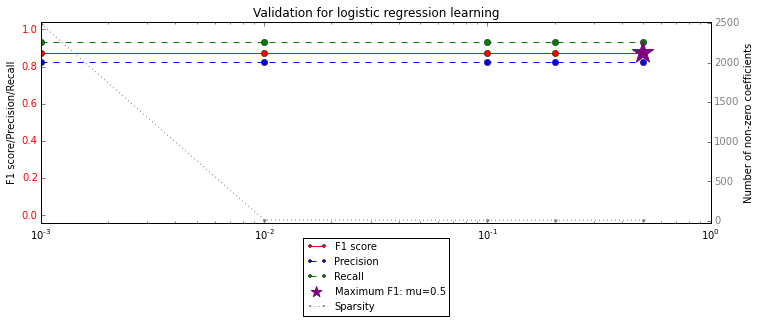

CPU times: user 2.73 s, sys: 58.8 ms, total: 2.79 s
Wall time: 2.89 s


<ddlite.ModelLog instance at 0x10ac5ca70>

In [150]:
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([0.5, 0.2, 0.1, 0.01, 0.001])
DDL.set_use_lfs(True)
%time DDL.learn_weights(sample=False, n_iter=500, alpha=0.5, mu=mu_seq,\
                        bias=True, verbose=True, log=True)

In [151]:
DDL.lowest_empirical_accuracy_lfs(n=10)

100% accuracy and 0 generalization score are "perfect"


Labeling function,Positive accuracy,Gen. score
another_name_between,75.47% (n=53),0.16 (n=22)
general_not_noun,81.25% (n=48),0.16 (n=20)
Labeling function,Negative accuracy,Gen. score
general_too_faraway,50.00% (n=6),0.17 (n=3)
another_name_between,83.33% (n=6),0.08 (n=4)


In [152]:
DDL.lf_summary_table()

Labelingfunction,Labeltype,Candidatecoverage,Candidateconflict,Positiveaccuracy,Positivegen. score,Negativeaccuracy,Negativegen. score
another_name_between,Both,100.00%,20.35%,75.47% (n=53),0.16 (n=22),83.33% (n=6),0.08 (n=4)
general_too_faraway,Negative,6.59%,6.59%,N/A,N/A,50.00% (n=6),0.17 (n=3)
general_pre_limit,Negative,15.12%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
has_key_word,Negative,77.13%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
remove_head_coach,Negative,10.85%,0.00%,N/A,N/A,-100.00% (n=0),1.00 (n=0)
general_not_noun,Positive,100.00%,18.22%,81.25% (n=48),0.16 (n=20),N/A,N/A


Since our development set is small, we can't evaluate LF performance particularly well. If we observe LFs with very low accuracy, poor generalization, and a sufficiently large sample size, this could be an indication that the LF is buggy.

In [153]:
DDL.get_classification_accuracy()

0.84705882352941175

In [154]:
DDL.show_log()

ID,# LFs,Test set size,Use LFs,Model,Precision,Recall,F1
0,6,31,True,Joint,0.750,0.947,0.837
1,6,43,True,Joint,0.857,0.889,0.873
2,6,59,True,Joint,0.875,0.897,0.886
3,6,60,True,Joint,0.889,0.952,0.920
4,6,60,True,Joint,0.929,0.929,0.929
5,6,60,True,Joint,0.000,0.000,0.000
6,6,60,True,Joint,0.000,0.000,0.000
7,6,60,True,Joint,0.860,0.925,0.892


After we train the model, except ground trueth we can sample some candidates from MindTagger to see whether their probability is high or low, which help us judge whether the outcome is good or not.

In [122]:
DDL.open_mindtagger(width='100%', height=3600)

Making sure MindTagger is installed. Hang on!


In [123]:
predicted = DDL.get_predicted_probability()

Another way to find some useful labeling function is to look at wrong predictions in validation. So here I extract the candidates which predict wrong.

In [125]:
low_gt=[]
high_gt=[]
conflict_gt=[]
i=0
for x in gt[0]:
    if predicted[x]>0.5 and gt[1][i]==-1: conflict_gt.append(x)
    elif predicted[x]<=0.5 and gt[1][i]==1: conflict_gt.append(x)
    i=i+1
R_conflict_gt = [R[i].tagged_sent for i in conflict_gt]
R_conflict_gt

[u'With Yahoo! Fantasy playoffs in full swing , here are four waiver-wire players who look ready to contribute this weekend : Toney Douglas , New Orleans -LRB- 24 percent owned -RRB- The veteran point guard continues to rack up stats for the Pelicans with {{Name}} -LRB- {{Injury part}} -RRB- sidelined .',
 u"{{Name}} says he was momentarily `` shocked '' when he felt someone grasping at his {{Injury part}} as he stood near the top of the key in the final minute of the New York Kicks ' game against the New Orleans Pelicans on Monday night .",
 u'The Clippers had a 2-0 lead over the Trail Blazers , after all , and even after losing Game 3 had reason to feel good with {{Name}} at starring and Blake Griffin showing signs of regaining his rhythm after missing 47 games since Christmas -LRB- hand , {{Injury part}} injuries and team-mandated suspension -RRB- .',
 u'The Minnesota Timberwolves have announced {{Name}} has been relieved of his interim head coaching duties , effective immediately ,

Now I only keep the candidates with probability larger than 0.8 to construct the knowledge base.

In [30]:
R_high = filter(lambda x: predicted[x.id]>0.8,R)

## Add additional information for each Relation

With the candidates we learned from news, it worthwhile to dig more information from them, such as news date and keyword.

In [43]:
# extract mention by their label(injury or name)
def get_mention_by_label(r,label): return ' '.join(r.mention1()) if r.e1_label == label else ' '.join(r.mention2())

In [44]:
# read news urls and extract date from them
f1 = open('data/urls_1.txt','r+')
f2 = open('data/urls_2.txt','r+')
temp1 = f1.read().splitlines()
temp2 = f2.read().splitlines()
temp2 = list(map(lambda x: x[0:19]+x[20:],temp2))
url_filtered = temp1 + [x for x in temp2 if x not in temp1]
print len(temp1)
print len(url_filtered)

date = map(lambda x: x[29:34],url_filtered)

432
561


In [45]:
def get_key_word(r): 
    for x in key_word:
        if x in r.lemmas:
            return x
    return ''


### Saving information in dictionary

In [47]:

R_dict = {}

for r in R_high:
    name  = get_mention_by_label(r,'Name')
    if R_dict.has_key(name):
        R_dict[name].append({'Injury Part': get_mention_by_label(r,'Injury Part'), 'News Date': date[r.id], 'Keyword': get_key_word(r)})
    else:
        R_dict[name]=[{'Injury Part': get_mention_by_label(r,'Injury Part'), 'News Date': date[r.id], 'Keyword': get_key_word(r)}]
        
    

In [ ]:
for key in R_dict.keys():
    

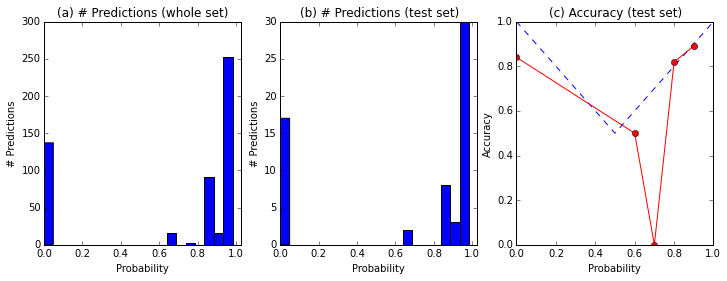

In [155]:
DDL.plot_calibration()